# Analysis of Per-shot Decoding

In this notebook, you will learn to analyze decoding performance on a per-shot basis by:

- simulating a quantum memory experiment with the repetition code,
- extracting a particular shot which led to a decoder failure, and
- visualising detectors which lit up in this failure event.

In [13]:
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
import stim
from deltakit.explorer import Client, enums, types

Client.set_token("8RmM5v8pUDPCew9SijMYQbXpYK5SHX2l")
client = Client.get_instance()

## Generate
Generate a quantum **Z**-memory experiment using the distance-7 repetition code with 5 rounds, and then add noise to it.

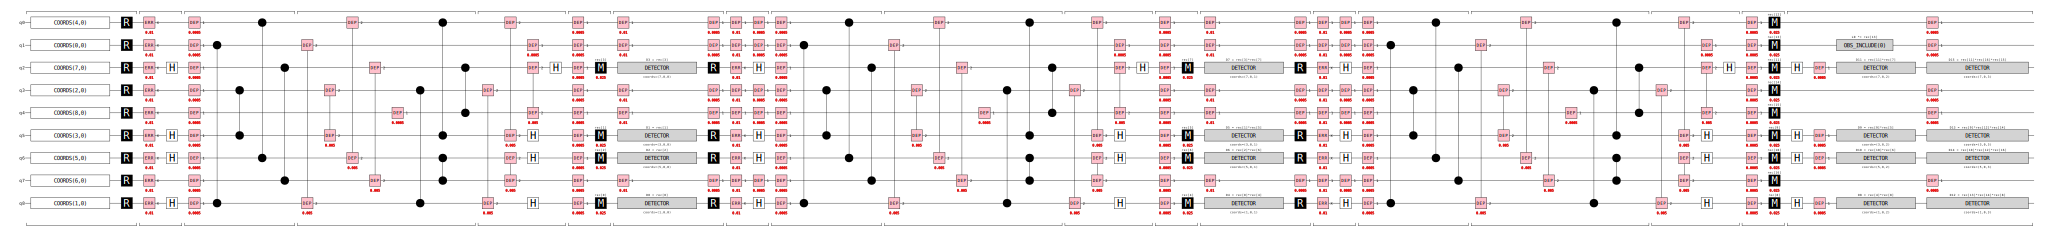

In [14]:
from deltakit.circuit.gates import PauliBasis, CZ, H, MZ, RZ
from deltakit.explorer.codes import RepetitionCode, css_code_memory_circuit
from deltakit.explorer.qpu import QPU, NativeGateSet, SI1000Noise
from deltakit_explorer.simulation import simulate_with_stim

# This was using `get_superconducting_noise`, but this is probable OK
noise_model = SI1000Noise(p=0.005)
native_gates = NativeGateSet(
    one_qubit_gates=[H],
    two_qubit_gates=[CZ],
    measurement_gates=[MZ],
    reset_gates=[RZ]
)

code = RepetitionCode(distance=5)
ideal_circuit = css_code_memory_circuit(code, num_rounds=3, logical_basis=PauliBasis.Z)
qpu = QPU(ideal_circuit.qubits, native_gates, noise_model)
noisy_circuit = qpu.compile_and_add_noise_to_circuit(ideal_circuit)

noisy_circuit.as_stim_circuit().diagram('timeline-svg')

## Simulate

Simulate the circuit 10,000 times, separating the measurements into detection events and logical flips.

In [15]:
from deltakit.explorer.simulation import simulate_with_stim
stim_circuit = noisy_circuit.as_stim_circuit()
measurements, _ = simulate_with_stim(stim_circuit, shots=10000)

detection_events, logical_flips = measurements.to_detectors_and_observables(stim_circuit)

## Decode

Use an AC decoder to get predictions of the logical flips based on detection events.

In [16]:
from deltakit.decode import ACDecoder
decoder = ACDecoder(noisy_circuit, client=client)
predicted_flips = decoder.decode_batch_to_logical_flip(detection_events.as_numpy(), parallel_jobs=4)

## Obtain an example failure and success

Iterate through the detectors, observables and predictions files together. If the prediction and observable values for a given shot disagree, this corresponding syndrome is saved as `fail_syndrome`, and gives an example of where the decoder failed. If prediction and observable agree, this is a successful decoding shot, and the syndrome is saved as `success_syndrome`. Break from the loop when you have examples for both successful and failed decoding.

In [17]:
fail_syndrome = None
success_syndrome = None

for pred, obs, det in zip(
       predicted_flips, logical_flips.as_numpy(), detection_events.as_numpy()
):
    syndrome = [i for i, bit in enumerate(det) if bit == 1]
    result =  {"detectors": det, "observable": obs, "prediction": pred, "syndrome": syndrome}
    if pred != obs:  # If prediction and observable disagree
        fail_syndrome = syndrome
        fail_result = result
    else:
        success_syndrome = syndrome
        success_result = result

    # Once we have instances of fail and success syndromes, we break out of the loop
    if fail_syndrome and success_syndrome:
        break

assert fail_syndrome, "Decoder did not fail to decode any syndrome. Please increase the noise and/or the number of shots to obtain a decoding failure example."
assert success_syndrome, "Decoder did not successfully decode any syndrome. Please reduce the noise and/or increase the number of shots to obtain a decoding success example."

## Visualise

Here, we plot the repetition code detectors (X axis) over time (Y axis) for the failure and success cases found above. Orange nodes correspond to detectors that "lit up". This type of plot is know as decoding graph, and it is useful to analyse and debug decoder behaviour.

Each node in the decoding graph corresponds to a detector and each edge corresponds to a potential error location. The detectors a particular error "light up" are those at either end of the corresponding edge. The graph can be constructed from the detector error model. Each detector has an associated coordinate. In this plot, the coordinates have the form `(X, Time)`, where `X` is the location of the auxiliary qubit associated with the stabiliser whose measurements form the detector. 

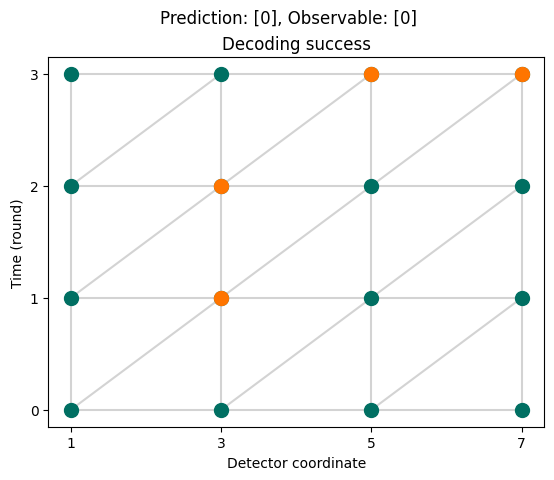

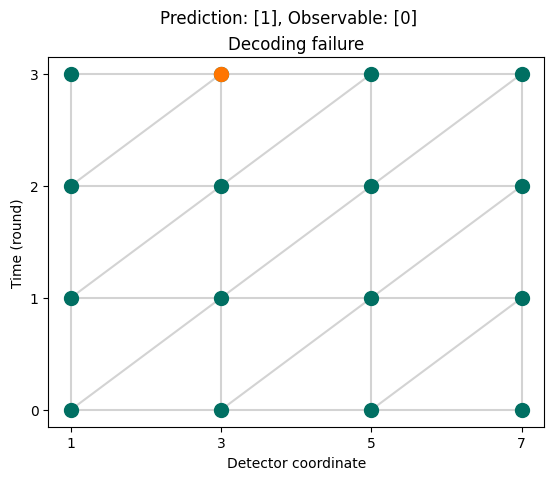

In [18]:
circuit = stim_circuit

def plot_decoding_graph(result, title):
    syndrome = result['syndrome']

    detector_coordinates = circuit.get_detector_coordinates()  # Get the coords of detectors
    nodes = np.array(list(detector_coordinates.values()))
    syndrome_nodes = nodes[syndrome, :]  # Syndrome nodes (we will colour these orange)

    dem = circuit.detector_error_model().flattened()
    node_pairs = [
        instruction.targets_copy() for instruction in dem
        if instruction.type == "error" and len(instruction.targets_copy()) == 2
    ]  # Pick out errors that arise from pairs of detectors firing
    edges = np.array([
        [detector_coordinates[detector.val] for detector in pair]
        for pair in node_pairs
        if pair[0].is_relative_detector_id() and pair[1].is_relative_detector_id()
    ])  # The coords of our edges, these correspond to places where errors can occur (we will colour these grey)

    # Plotting
    for start, end in edges:
        plt.plot(
            [start[0], end[0]], [start[-1], end[-1]],
            color="lightgray", zorder=-1)  # Plot the edges

    plt.scatter(nodes[:,0], nodes[:,-1], s=100, c='#006F62')  # Plot all the detectors in blue
    plt.scatter(syndrome_nodes[:,0], syndrome_nodes[:,-1], s=100, c='#FF7500')  # Colour the detectors that lit up in orange
    plt.xticks(list(set(nodes[:,0])))  # Set the x-axis scale
    plt.yticks(list(set(nodes[:,-1])))  # Set the y-axis scale
    plt.grid(False)
    plt.xlabel("Detector coordinate")
    plt.ylabel("Time (round)")
    plt.title(title)
    plt.suptitle(f"Prediction: {result['prediction']}, Observable: {result['observable']}")
    plt.show()

plot_decoding_graph(success_result, title="Decoding success")
plot_decoding_graph(fail_result, title="Decoding failure")